# AutoEncoder Anomaly Detection

Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import pickle

Configure plots

In [3]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = (10,6)

Constants

In [4]:
RANDOM_SEED = 37
LABELS      = ['normal', 'fraud']

The data is the credit card kaggle dataset, with 492 frauds out of 284,807 transactions
- https://www.kaggle.com/mlg-ulb/creditcardfraud
- already transformed with PCA

In [7]:
df = pd.read_csv('datasets/creditcard.csv')

In [7]:
print(df.shape)
print(df.head())

(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

**Check for missing values**

In [8]:
df.isnull().values.any()

False

### Plot class distribution

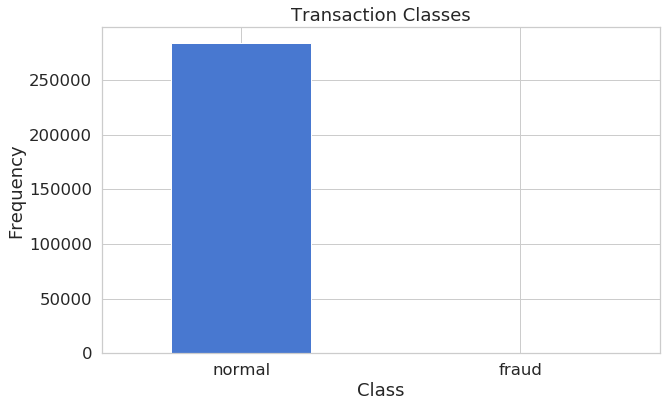

In [9]:
class_count = pd.value_counts(df['Class'], sort=True)
class_count.plot(kind='bar', rot=0)
plt.title("Transaction Classes")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [10]:
frauds = df[df.Class==1]
normal = df[df.Class==0]

### Prepare for autoencoder
- drop time column
- use standard scler on amount column

In [12]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

- only train on 'good' data
- drop the label

In [13]:
X_train, X_test = train_test_split(data, test_size=.25, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class==0]
X_train = X_train.drop(['Class'], axis=1)

y_test  = X_test['Class']
X_test  = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test  = X_test.values

- determine the shape of the input layer

In [14]:
X_train.shape

(213235, 29)

### Build the autoencoder

In [24]:
input_dim    = X_train.shape[1]
encoding_dim = input_dim//2

in_layer = Input(shape=(input_dim,))

encoder  = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(1e-5))(in_layer)
encoder  = Dense(encoding_dim//2, activation='relu')(encoder)

decoder  = Dense(encoding_dim//2, activation='tanh')(encoder)
decoder  = Dense(encoding_dim, activation='relu')(decoder)

out_layer = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=in_layer, outputs=out_layer)